In [10]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
from problem import Poisson_2d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [12]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]

def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    grad_u = grad(u_pde, x_pde)
    u_x = grad_u[:, [0]]
    u_y = grad_u[:, [1]]

    u_xx = grad(u_x, x_pde)[:, [0]]
    u_yy = grad(u_y, x_pde)[:, [1]]

    pde_value = u_xx + u_yy
    return pde_value

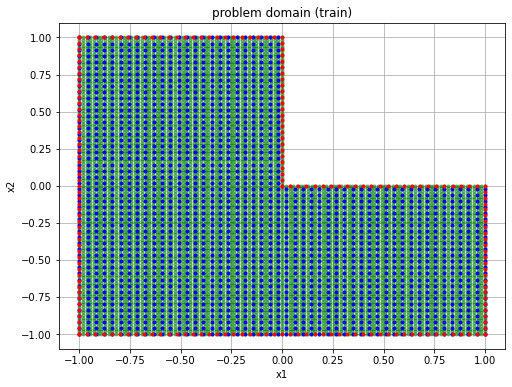

In [13]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_test = data['target_test'].item()['u']


plot_domain_2d(x_pde=x_pde, x_bd=x_bd, x_test=x_test)


In [14]:
x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_test = torch.from_numpy(target_test).float()
print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_test.shape, target_test.shape)

torch.Size([1875, 2]) torch.Size([1875, 1])
torch.Size([204, 2]) torch.Size([204, 1])
torch.Size([9296, 2]) torch.Size([9296, 1])


In [15]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [16]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_test = target_test.cuda()


In [17]:

def train(width):
    model  = FCNet(input_dim=2, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [18]:
width_vec = [100,250,500,750,1000]
result_all = []
for width in width_vec:
    print(width,'.....................')

    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

100 .....................
0 1497.0093994140625
100 1488.635009765625
200 1463.4298095703125
300 1407.4901123046875
400 1298.4381103515625
500 1147.0838623046875
600 954.3817749023438
700 709.1726684570312
800 451.01806640625
900 244.69012451171875
1000 124.1963882446289
1100 65.47360229492188
1200 37.54676055908203
1300 23.80872344970703
1400 16.29819107055664
1500 11.687453269958496
1600 8.976058959960938
1700 7.304365158081055
1800 6.147174835205078
1900 5.265717506408691
2000 4.559514045715332
2100 4.146363258361816
2200 3.7882285118103027
2300 3.4804413318634033
2400 3.2183074951171875
2500 2.99674391746521
2600 2.809551954269409
2700 2.649629592895508
2800 2.5103955268859863
2900 2.386821985244751
3000 2.2753381729125977
3100 2.1732356548309326
3200 2.078256130218506
3300 1.9883768558502197
3400 1.901794672012329
3500 1.8171122074127197
3600 1.7337262630462646
3700 1.652083396911621
3800 1.5731651782989502
3900 1.4975850582122803
4000 1.4253787994384766
4100 1.3764081001281738
420

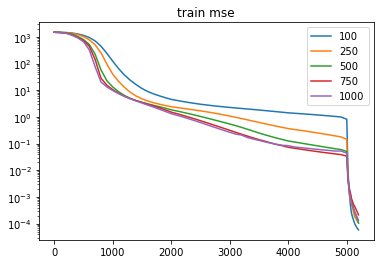

In [23]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

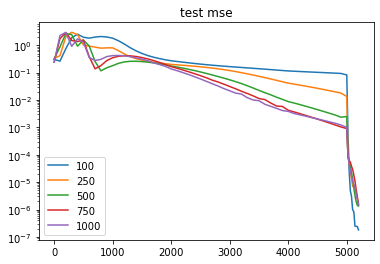

In [24]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [25]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [26]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')